In [1]:
!pip install d2l
!pip install matplotlib==3.0.2

     |████████████████████████████████| 82 kB 720 kB/s 
     |████████████████████████████████| 9.9 MB 16.4 MB/s 
     |████████████████████████████████| 61 kB 9.3 MB/s 
     |████████████████████████████████| 11.2 MB 45.5 MB/s 
     |████████████████████████████████| 900 kB 41.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

     |████████████████████████████████| 12.9 MB 5.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## High-Dimensional Linear Regression

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

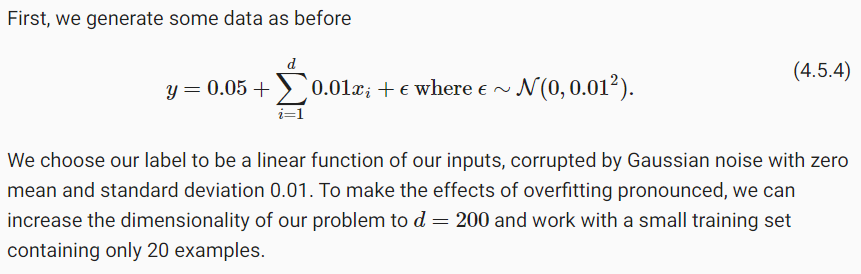

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## **Implementation from Scratch**

### Initializing Model Parameters

In [3]:
# First, we will define a function to randomly initialize our model parameters

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### Defining L_2 Norm Penalty

In [4]:
# Perhaps the most convenient way to implement this penalty is to square all terms in place and sum them up.

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### Defining the Training Loop

The following code fits a model on the training set and evaluates it on the test set. The linear network and the squared loss have not changed since Section 3, so we will just import them via d2l.linreg and d2l.squared_loss. The only change here is that our loss now includes the penalty term

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

### Training without Regularization

We now run this code with lambd = 0, disabling weight decay. Note that we overfit badly, decreasing the training error but not the test error—a textbook case of overfitting.

L2 norm of w: 13.501559257507324


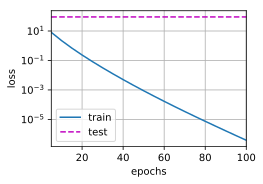

In [6]:
train(lambd=0)

### Using Weight Decay

L2 norm of w: 0.3230636417865753


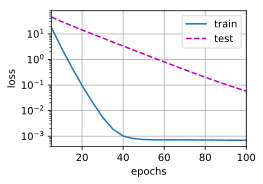

In [7]:
# we run with substantial weight decay. Note that the training error increases but the test error decreases. 
#This is precisely the effect we expect from regularization

train(lambd=3)

## Concise Implementation

Because weight decay is ubiquitous in neural network optimization, the deep learning framework makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, the optimizer must touch each parameter once anyway.

In the following code, we specify the weight decay hyperparameter directly through weight_decay when instantiating our optimizer. By default, PyTorch decays both weights and biases simultaneously. Here we only set weight_decay for the weight, so the bias parameter  will not decay.

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

Plotnya terlihat identik dengan plot ketika diterapkan penurunan berat badan dari awal. Namun, mereka berjalan jauh lebih cepat dan lebih mudah diterapkan, manfaat yang akan menjadi lebih jelas untuk masalah yang lebih besar.

L2 norm of w: 13.609952926635742


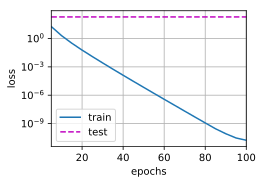

In [9]:
train_concise(0)

L2 norm of w: 0.35368794202804565


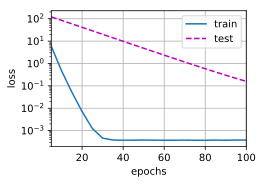

In [10]:
train_concise(3)

Sejauh ini, kita hanya menyentuh satu gagasan tentang apa yang merupakan fungsi linier sederhana. Selain itu, apa yang merupakan fungsi nonlinier sederhana dapat menjadi pertanyaan yang lebih kompleks.

**Misalnya**, mereproduksi ruang kernel Hilbert (RKHS) memungkinkan seseorang untuk menerapkan alat yang diperkenalkan untuk fungsi linier dalam konteks nonlinier. **Sayangnya**, algoritme berbasis RKHS cenderung memiliki skala yang buruk untuk data yang besar dan berdimensi tinggi.

disini akan digunakan heuristik sederhana untuk menerapkan pembusukan bobot pada semua layer dari deep network.

## Summary



*   Regularisasi adalah metode umum untuk menangani overfitting. Hal ini menambahkan istilah penalti ke fungsi kerugian pada set pelatihan untuk mengurangi kompleksitas model yang dipelajari.

*   Salah satu pilihan khusus untuk menjaga model tetap sederhana adalah penurunan berat badan menggunakan penalti L_2. Hal ini menyebabkan pembusukan bobot (weight decay) dalam langkah-langkah pembaruan algoritma pembelajaran.
*   Fungsi peluruhan bobot (weight decay) disediakan dalam pengoptimal dari kerangka kerja pembelajaran mendalam.


*   Kumpulan parameter yang berbeda dapat memiliki perilaku pembaruan yang berbeda dalam loop training yang sama.

